In [1]:
import h5py
import os
from os.path import isfile
import numpy as np    
import scipy.io
import cbf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import pandas as pd
import pyFAI, fabio
from PIL import Image
from scipy.ndimage.filters import median_filter
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from datetime import date

from scipy import optimize
from scipy.optimize import curve_fit
#import tifffile as tf
import pwlf

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
# Ih reference values
Ih_ref = np.array([1.61297476, 1.71327851, 1.8264895 , 2.35318655, 2.79464445,
       3.03451657, 3.22634856, 3.27789344, 3.33837302, 3.6533046 ])

In [3]:
!ls ../07-analysis-waxs/

empty_capillary_296_00001.pkl	HydLys_0p25_2_00010_1.pkl
G2p1_180_00010_00001_00001.pkl	HydLys_0p25_2_00010_2.pkl
HydLys_0p25_2_00003_1.pkl	HydLys_0p25_2_00010_3.pkl
HydLys_0p25_2_00003_2.pkl	HydLys_0p25_2_00011_1.pkl
HydLys_0p25_2_00003_3.pkl	HydLys_0p25_2_00011_2.pkl
HydLys_0p25_2_00005_1.pkl	HydLys_0p25_2_00011_3.pkl
HydLys_0p25_2_00005_2.pkl	HydLys_0p25_2_00012_1.pkl
HydLys_0p25_2_00005_3.pkl	HydLys_0p25_2_00012_2.pkl
HydLys_0p25_2_00006_1.pkl	HydLys_0p25_2_00012_3.pkl
HydLys_0p25_2_00006_2.pkl	HydLys_0p25_2_00013_1.pkl
HydLys_0p25_2_00006_3.pkl	HydLys_0p25_2_00013_2.pkl
HydLys_0p25_2_00007_1.pkl	HydLys_0p25_2_00013_3.pkl
HydLys_0p25_2_00007_2.pkl	HydLys_0p25_2_00014_1.pkl
HydLys_0p25_2_00007_3.pkl	HydLys_0p25_2_00014_2.pkl
HydLys_0p25_2_00008_1.pkl	HydLys_0p25_2_00014_3.pkl
HydLys_0p25_2_00008_2.pkl	HydLys_0p25_2_00015_1.pkl
HydLys_0p25_2_00008_3.pkl	HydLys_0p25_2_00015_2.pkl
HydLys_0p25_2_00009_1.pkl	HydLys_0p25_2_00015_3.pkl
HydLys_0p25_2_00009_2.pkl	q_values_2.npy
HydLys_0p25_2_

In [4]:
analysisdir = '/home/maddabin/p10-llt/processed/maddalena/07-analysis-waxs'

## load q map

In [5]:
# sample = 'G2p1_180_00010_00001_00001'
# data_q = pd.read_pickle(f'{analysisdir}/{sample}.pkl')
qval = np.load('../07-analysis-waxs/q_values_2.npy') #data_q['qval']

In [6]:
qval.shape

(300,)

# plotting signgle

In [7]:
!ls ../07-analysis-waxs 

empty_capillary_296_00001.pkl	HydLys_0p25_2_00010_1.pkl
G2p1_180_00010_00001_00001.pkl	HydLys_0p25_2_00010_2.pkl
HydLys_0p25_2_00003_1.pkl	HydLys_0p25_2_00010_3.pkl
HydLys_0p25_2_00003_2.pkl	HydLys_0p25_2_00011_1.pkl
HydLys_0p25_2_00003_3.pkl	HydLys_0p25_2_00011_2.pkl
HydLys_0p25_2_00005_1.pkl	HydLys_0p25_2_00011_3.pkl
HydLys_0p25_2_00005_2.pkl	HydLys_0p25_2_00012_1.pkl
HydLys_0p25_2_00005_3.pkl	HydLys_0p25_2_00012_2.pkl
HydLys_0p25_2_00006_1.pkl	HydLys_0p25_2_00012_3.pkl
HydLys_0p25_2_00006_2.pkl	HydLys_0p25_2_00013_1.pkl
HydLys_0p25_2_00006_3.pkl	HydLys_0p25_2_00013_2.pkl
HydLys_0p25_2_00007_1.pkl	HydLys_0p25_2_00013_3.pkl
HydLys_0p25_2_00007_2.pkl	HydLys_0p25_2_00014_1.pkl
HydLys_0p25_2_00007_3.pkl	HydLys_0p25_2_00014_2.pkl
HydLys_0p25_2_00008_1.pkl	HydLys_0p25_2_00014_3.pkl
HydLys_0p25_2_00008_2.pkl	HydLys_0p25_2_00015_1.pkl
HydLys_0p25_2_00008_3.pkl	HydLys_0p25_2_00015_2.pkl
HydLys_0p25_2_00009_1.pkl	HydLys_0p25_2_00015_3.pkl
HydLys_0p25_2_00009_2.pkl	q_values_2.npy
HydLys_0p25_2_

# Iq vs time

In [8]:
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

In [9]:
def fit(function,x,y,p0=None,sigma=None,bounds=[None,None]):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma,bounds=bounds)
    xc = np.linspace(min(x),max(x),100)
    curve = function(xc,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,xc,curve,perr

def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def gaussian_off(x, a, x0, sigma, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

### 290 K

In [10]:
samplename='HydLys_0p25_2_00003_3'
data = pd.read_pickle(f'{analysisdir}/{samplename}.pkl')
data['Iq_all'].shape

(200,)

In [11]:
plt.colorbar?

<IPython.core.display.Javascript object>


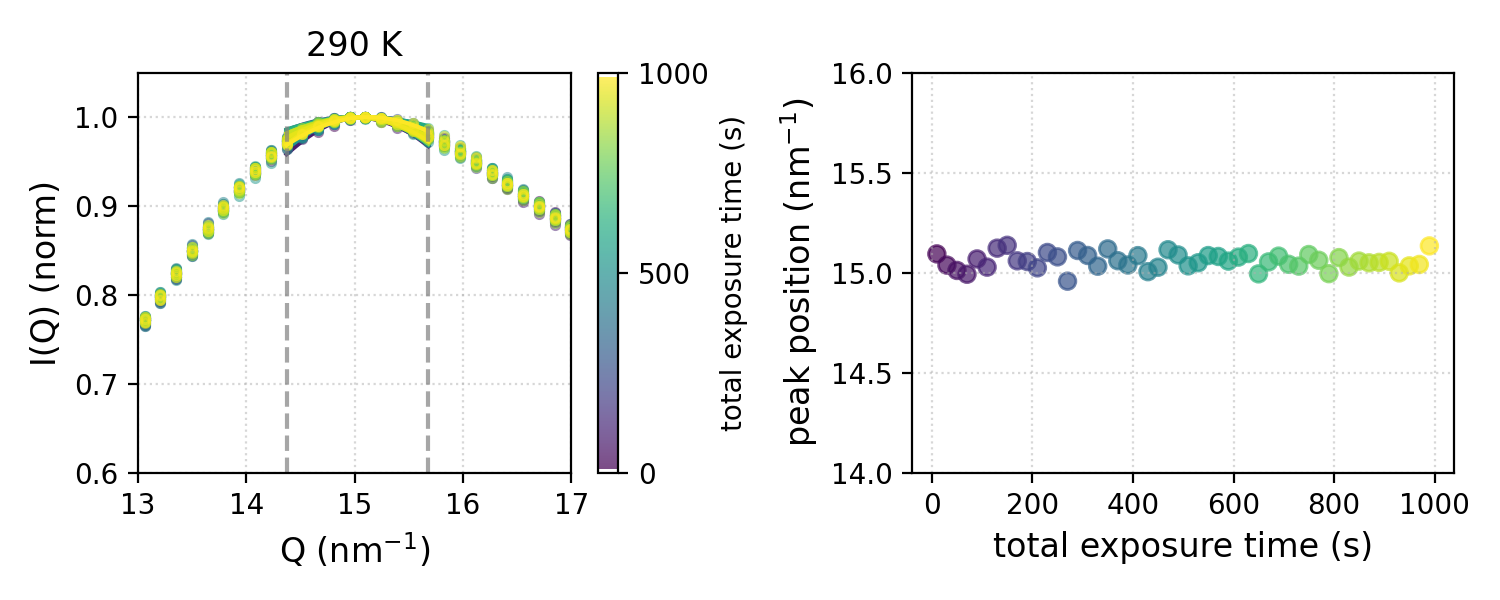

<IPython.core.display.Javascript object>


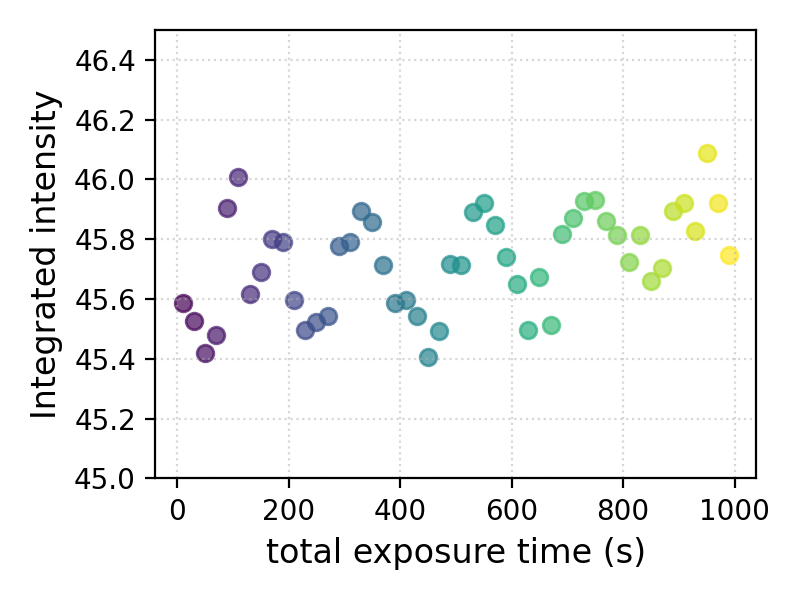

In [18]:
# fig = plt.figure()
fig, (a1,a2) = plt.subplots(1,2,figsize=(7.5,3), tight_layout=True)
fig2, a3 = plt.subplots(1,1,figsize=(4,3), tight_layout=True)

rebin = 50
time = np.arange(0,1000,.5)
y = np.mean(np.array(data['Iq_all'][:]).reshape(-1,rebin), axis=0)

time_reb = np.mean(np.array(time).reshape(-1,len(time)//rebin), axis=1)
col = plt.cm.viridis(np.linspace(0,1,len(y)))
fmin, fmax = 18, 28
popts_x, popts_y = [], []

for i in range(len(y)):
    x = np.mean(np.array(qval).reshape(-1,3), axis = -1)
    yy = np.mean(y[i].reshape(-1,3),  axis = -1)
    yy_smooth = gaussian_filter(yy, sigma=1.5)

    popt,xc,curve,perr = fit(gaussian_off, x[fmin:fmax], yy[fmin:fmax], #yy_smooth[fmin:fmax],
                             p0=[2,15,3,3], bounds=((0,13,1.1,0), (np.inf,17,np.inf,np.inf)))
#     if popt[2] < 2: print(popt[2])
    a1.plot(xc, curve/np.max(curve), color=col[i])
    a1.plot(x, yy_smooth/np.max(yy_smooth), color=col[i], marker='o', ms=3, fillstyle='none', alpha=.5, ls='')
    popts_x.append(time_reb[i])
    popts_y.append(popt[1])
    
    a3.scatter(time_reb[i], np.trapz(yy[fmin:fmax]),  color=col[i], alpha=0.7)

z = np.arange(len(popts_y))
sc = a2.scatter(popts_x, popts_y, c=popts_x, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(sc, ax=a1, label='total exposure time (s)')
# cbar.set_yticks([0,250,500,750,1000], [0,250,500,750,1000])
cbar.set_ticks( [0,500,1000])
cbar.set_ticklabels( [0,500,1000])


# for i in Ih_ref: plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
a1.axvline(x=x[fmin], ls='--', c='gray', alpha=.7)
a1.axvline(x=x[fmax-1], ls='--', c='gray', alpha=.7)
a1.set_title('290 K')
a1.grid(ls=':', alpha=.5)
#plt.legend(ncol=6, fontsize = 'small')
a1.set_xlabel(r'Q ($\rm nm^{-1}$)', fontsize=12)
a1.set_ylabel('I(Q) (norm)', fontsize=12)
a1.set_ylim(.6, 1.05)
a1.set_xlim(13,17)

a2.grid(ls=':', alpha=.5)
a2.set_xlabel('total exposure time (s)', fontsize=12)
a2.set_ylabel(r'peak position ($\rm nm^{-1}$)', fontsize=12)
a2.set_ylim(14, 16)

a3.grid(ls=':', alpha=.5)
a3.set_xlabel('total exposure time (s)', fontsize=12)
a3.set_ylabel(r'Integrated intensity', fontsize=12)
a3.set_ylim(45,46.5)

# a2.set_xticks([0,200,400,600,800,1000])
# fig.savefig('../09-plots/time-resolved-waxs.png', dpi=300)
plt.show()

# Plot all

In [13]:
!ls ../07-analysis-waxs/empty*.pkl

../07-analysis-waxs/empty_capillary_296_00001.pkl


In [14]:
all_files = os.listdir('../07-analysis-waxs/')
files = []

for item in all_files:
#     if (item.startswith('HydLys_0p25_2') and item.endswith('_2.pkl')):
    if (item.startswith('HydLys_0p25_2') and item.endswith('_3.pkl')):
        files.append(item)
files_sorted = sorted(files)

In [15]:
bkg_file = '../07-analysis-waxs/empty_capillary_296_00001.pkl'
bkg_data = pd.read_pickle(bkg_file)

In [16]:
# Iq_bkg = np.array(bkg_data['Iq_all'][:300])
# print(Iq_bkg.shape)
# bgi = np.mean(Iq_bkg.reshape(-1,1), axis=-1)
# bg = np.mean(Iq_bkg.reshape(-1,1), axis=-1)
# print(bg.shape)


bgi = np.mean(np.array(bkg_data['Iq_all'][:n]).reshape(-1,rebin), axis=0)
print(bgi.shape)
bg = np.mean(bgi[0].reshape(-1,3), axis=-1)
print(bg.shape)

NameError: name 'n' is not defined

In [ ]:
fig = plt.figure()
off, n = 0, 300
temps = np.arange(290,170,-10)
col = plt.cm.coolwarm_r(np.linspace(0,1,len(temps)))
xs, ys = [], []

for count,file in enumerate(files_sorted[:]):
    label = file.split('/')[-1]
    data = pd.read_pickle(f'../07-analysis-waxs/{file}')
    
    off = count*2
    rebin = 1
    yi = np.mean(np.array(data['Iq_all'][:n]).reshape(-1,rebin), axis=0)
    
    x = np.mean(np.array(qval).reshape(-1,3), axis=-1)
    y = np.mean(yi[0].reshape(-1,3), axis=-1)
    y = y - np.average(y[91:])
    f = .1
    y_bg = y - f*bg
    
    norm = np.max(y)
    ys.append(y)
    xs.append(x)
    
    plt.plot(x, y/norm, lw=1.5, ls='-', c=col[count], label=f'{temps[count]}K')

# for i in Ih_ref:
#     plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')

# plt.axvline(x=x[91], ls='--', c='gray')

plt.title(f'first 1000 frames of each run')
plt.grid(ls=':', alpha=.5)
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)    
plt.ylim(0, None)
plt.xlim(12,24)
plt.legend(ncol=2, fontsize='small', handlelength=1)
plt.show()

In [ ]:
# np.savez("../02-sources/waxs_temps", Iq=ys, q=xs, temp=temps)

In [ ]:
!ls ../02-sources

In [ ]:
#samplename='G5p1_1_180_00019'
fig = plt.figure()

#samplenames=np.arange(1,16)#['T1p1_1_180_00001','T1p1_1_180_00002','T1p1_1_180_00003','T1p1_1_180_00004', 'T1p1_1_180_00009', 'T1p1_1_180_00010','T1p1_1_180_00012','T1p1_1_180_00027']#, 'T1p1_1_180_00002']#, 'G5p2_1_180_00007','G5p2_1_180_00008', 'G5p2_1_180_00009', 'G5p2_1_180_00010', 'G5p2_1_180_00012', 'G5p2_1_180_00014']#, 'G5p1_1_296_00002']
samplenames=['HydLys_0p29_2_00001', 'HydLys_0p29_3_00004', 'HydLys_0p25_2_00004']

temps = [290, 280,270,260,250,240,235,230,225,220,215,210,200,190,180]

off = 0

col = np.array(sns.color_palette('viridis', len(samplenames)))

for count, samplename in enumerate(samplenames):
    
    
    #data = pd.read_pickle(f'../analysis/HydLys_0p29_2_{samplename:05}.pkl')
    data = pd.read_pickle(f'../analysis/{samplename}.pkl')
    data['Iq_all'].shape
    
    off= count*2

    rebin = 1

    y = np.mean(np.array(data['Iq_all'][:100]).reshape(-1,rebin), axis=0)

    


    for i in range(len(y)):
        #plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1) + off, 
         #        lw=2, color = col[count],alpha = 0.8, label = f'{samplename}')
        
        
        plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1)/np.mean(y[i].reshape(-1,3), axis = -1)[20], 
                 lw=2, color = col[count],alpha = 0.8, label = f'{samplename}')


        #plt.plot(qval, y[i]+off, 
         #        color = col[i], marker=lss[count], ls='', label = f'bins{samplename}', alpha =0.5)#, marker='o', alpha = 0.5)


#plt.axvline(x = np.mean(np.array(qval).reshape(-1,3), axis = -1)[20])

plt.title(f'first 1000 frames of each run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
#plt.ylim(0, .5)

plt.xlim(12,25)
plt.legend(ncol=2)







# powders cooling

In [ ]:
!ls ../analysis/Hyd*

In [ ]:
#samplename='G5p1_1_180_00019'
fig = plt.figure()




samplenames=np.arange(1,16)#['T1p1_1_180_00001','T1p1_1_180_00002','T1p1_1_180_00003','T1p1_1_180_00004', 'T1p1_1_180_00009', 'T1p1_1_180_00010','T1p1_1_180_00012','T1p1_1_180_00027']#, 'T1p1_1_180_00002']#, 'G5p2_1_180_00007','G5p2_1_180_00008', 'G5p2_1_180_00009', 'G5p2_1_180_00010', 'G5p2_1_180_00012', 'G5p2_1_180_00014']#, 'G5p1_1_296_00002']
#samplenames=['HydLys_0p29_2_00001', 'HydLys_0p29_2_00001_2']

temps = [290, 280,270,260,250,240,235,230,225,220,215,210,200,190,180]

off = 0

col = np.array(sns.color_palette('coolwarm_r', len(samplenames)))

for count, samplename in enumerate(samplenames):
    
    
    data = pd.read_pickle(f'../analysis/HydLys_0p29_2_{samplename:05}.pkl')
    #data = pd.read_pickle(f'../analysis/{samplename}.pkl')
    data['Iq_all'].shape


    rebin = 1

    y = np.mean(np.array(data['Iq_all'][:100]).reshape(-1,rebin), axis=0)

    


    for i in range(len(y)):
        plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1)/np.mean(y[i].reshape(-1,3), axis = -1)[20], 
                 lw=2, color = col[count],alpha = 0.8, label = f'{samplename}, T={temps[count]}')


        #plt.plot(qval, y[i]+off, 
         #        color = col[i], marker=lss[count], ls='', label = f'bins{samplename}', alpha =0.5)#, marker='o', alpha = 0.5)


plt.axvline(x = np.mean(np.array(qval).reshape(-1,3), axis = -1)[20])

plt.title(f'first 1000 frames of each run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
#plt.ylim(0, .5)

plt.xlim(12,25)
plt.legend(ncol=2)






# trehalose cooling down

In [ ]:
#samplename='G5p1_1_180_00019'
fig = plt.figure()
samplenames=['T1p1_1_180_00001','T1p1_1_180_00002','T1p1_1_180_00003','T1p1_1_180_00004', 'T1p1_1_180_00009', 'T1p1_1_180_00010','T1p1_1_180_00012','T1p1_1_180_00027']#, 'T1p1_1_180_00002']#, 'G5p2_1_180_00007','G5p2_1_180_00008', 'G5p2_1_180_00009', 'G5p2_1_180_00010', 'G5p2_1_180_00012', 'G5p2_1_180_00014']#, 'G5p1_1_296_00002']



lss=['o', 'v', 's']

off = 0

col = np.array(sns.color_palette('coolwarm_r', len(samplenames)))

for count, samplename in enumerate(samplenames):
    
    

    data = pd.read_pickle(f'../analysis/{samplename}.pkl')
    data['Iq_all'].shape


    rebin = 1

    y = np.mean(np.array(data['Iq_all'][:100]).reshape(-1,rebin), axis=0)

    


    for i in range(len(y)):
        plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1), 
                 lw=3, color = col[count],alpha = 0.8, label = f'{samplename}')


        #plt.plot(qval, y[i]+off, 
         #        color = col[i], marker=lss[count], ls='', label = f'bins{samplename}', alpha =0.5)#, marker='o', alpha = 0.5)



plt.title(f'first 1000 frames of each run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
plt.ylim(0, .5)

plt.xlim(12,25)
plt.legend(ncol=2)





In [ ]:
#samplename='G5p1_1_180_00019'
fig = plt.figure()
samplenames=['G2p3_2_170_00002','G2p3_2_170_00003','G2p3_2_170_00004', 'G2p3_2_170_00006']#, 'G5p2_1_180_00007','G5p2_1_180_00008', 'G5p2_1_180_00009', 'G5p2_1_180_00010', 'G5p2_1_180_00012', 'G5p2_1_180_00014']#, 'G5p1_1_296_00002']



lss=['o', 'v', 's']

off = 0

col = np.array(sns.color_palette('coolwarm_r', len(samplenames)))

for count, samplename in enumerate(samplenames):
    
    

    data = pd.read_pickle(f'../analysis/{samplename}.pkl')
    data['Iq_all'].shape


    rebin = 1

    y = np.mean(np.array(data['Iq_all'][:100]).reshape(-1,rebin), axis=0)

    


    for i in range(len(y)):
        plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1), 
                 lw=3, color = col[count],alpha = 0.8, label = f'{samplename}')


        #plt.plot(qval, y[i]+off, 
         #        color = col[i], marker=lss[count], ls='', label = f'bins{samplename}', alpha =0.5)#, marker='o', alpha = 0.5)



plt.title(f'first 1000 frames of each run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
plt.ylim(0, .5)

plt.xlim(12,25)
plt.legend(ncol=2)




# cooling down G5.2

<IPython.core.display.Javascript object>


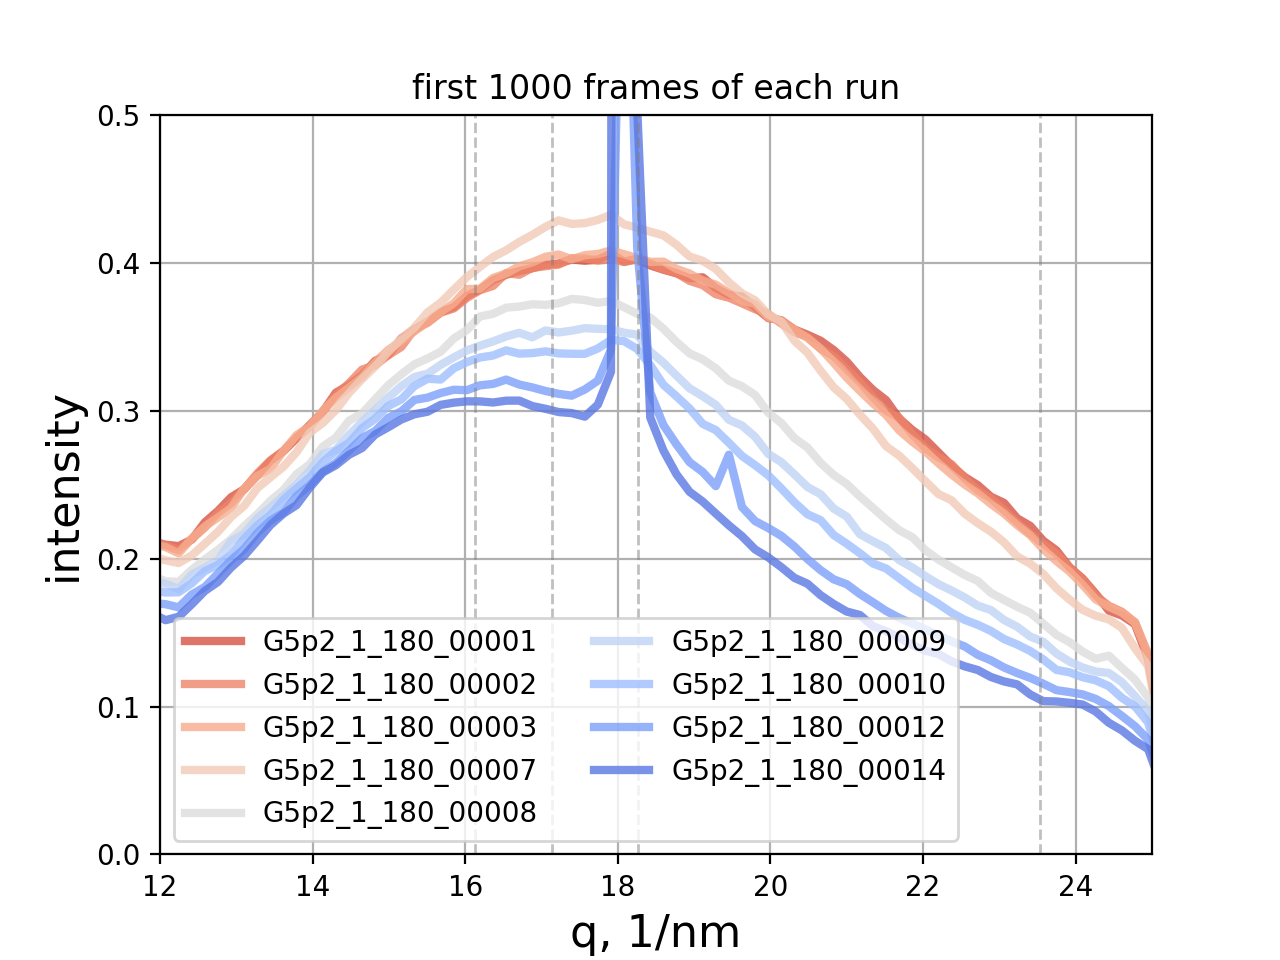

In [222]:
#samplename='G5p1_1_180_00019'
fig = plt.figure()
samplenames=['G5p2_1_180_00001','G5p2_1_180_00002', 'G5p2_1_180_00003', 'G5p2_1_180_00007','G5p2_1_180_00008', 'G5p2_1_180_00009', 'G5p2_1_180_00010', 'G5p2_1_180_00012', 'G5p2_1_180_00014']#, 'G5p1_1_296_00002']



lss=['o', 'v', 's']

off = 0

col = np.array(sns.color_palette('coolwarm_r', len(samplenames)))

for count, samplename in enumerate(samplenames):
    
    

    data = pd.read_pickle(f'../analysis/{samplename}.pkl')
    data['Iq_all'].shape


    rebin = 1

    y = np.mean(np.array(data['Iq_all'][:100]).reshape(-1,rebin), axis=0)

    


    for i in range(len(y)):
        plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1), 
                 lw=3, color = col[count],alpha = 0.8, label = f'{samplename}')


        #plt.plot(qval, y[i]+off, 
         #        color = col[i], marker=lss[count], ls='', label = f'bins{samplename}', alpha =0.5)#, marker='o', alpha = 0.5)



plt.title(f'first 1000 frames of each run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
plt.ylim(0, .5)

plt.xlim(12,25)
plt.legend(ncol=2)



# compare G5p1_1

<IPython.core.display.Javascript object>


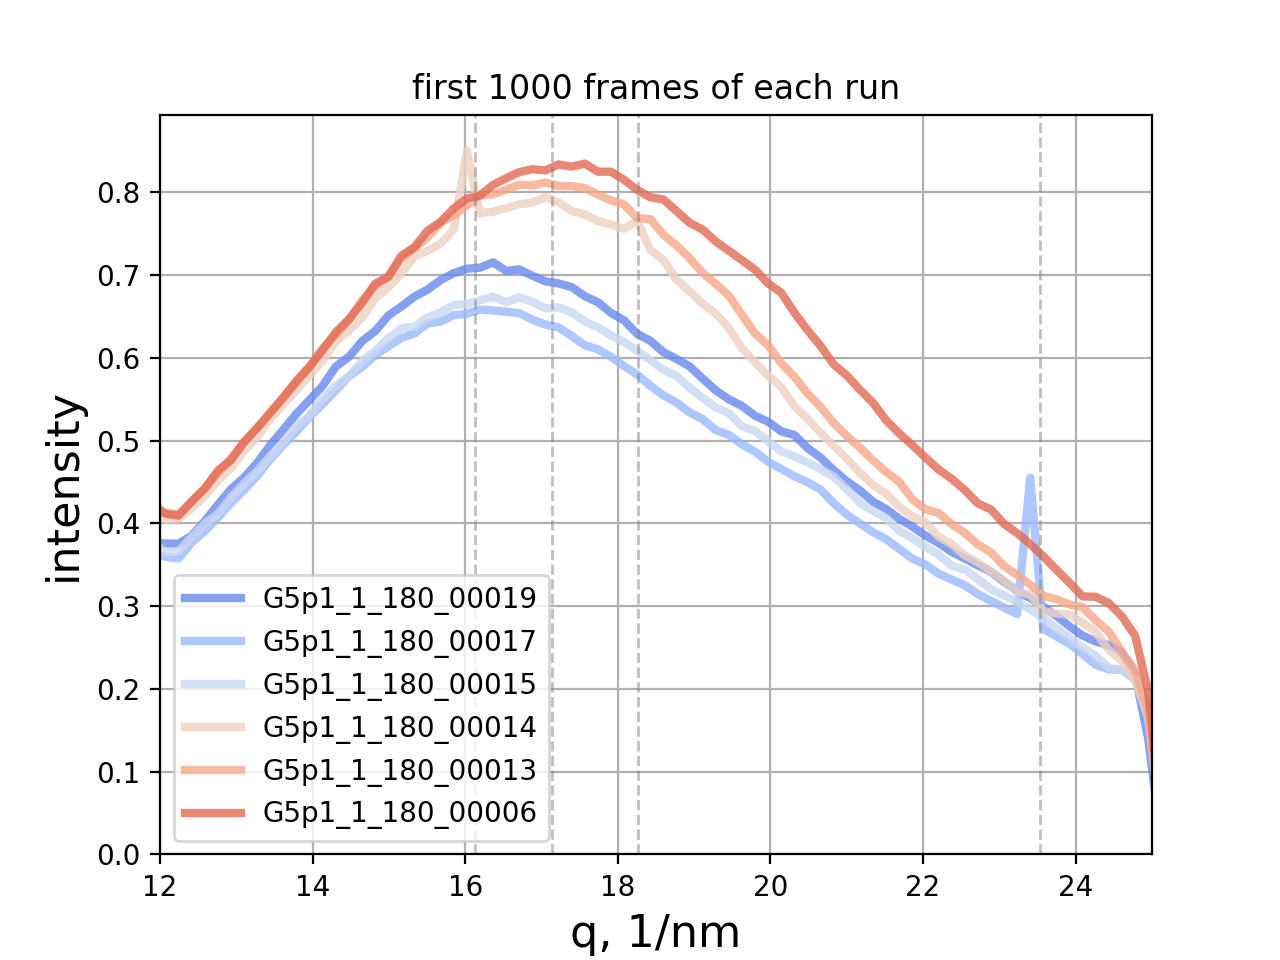

In [218]:
#samplename='G5p1_1_180_00019'
fig = plt.figure()
samplenames=['G5p1_1_180_00019','G5p1_1_180_00017','G5p1_1_180_00015', 'G5p1_1_180_00014', 'G5p1_1_180_00013', 'G5p1_1_180_00006']#, 'G5p1_1_296_00002']

lss=['o', 'v', 's']

off = 0

col = np.array(sns.color_palette('coolwarm', len(samplenames)))

for count, samplename in enumerate(samplenames):
    
    

    data = pd.read_pickle(f'../analysis/{samplename}.pkl')
    data['Iq_all'].shape


    rebin = 1

    y = np.mean(np.array(data['Iq_all'][:100]).reshape(-1,rebin), axis=0)

    


    for i in range(len(y)):
        plt.plot(np.mean(np.array(qval).reshape(-1,3), axis = -1), np.mean(y[i].reshape(-1,3), axis = -1), 
                 lw=3, alpha = 0.8, color = col[count], label = f'{samplename}')


        #plt.plot(qval, y[i]+off, 
         #        color = col[i], marker=lss[count], ls='', label = f'bins{samplename}', alpha =0.5)#, marker='o', alpha = 0.5)



plt.title(f'first 1000 frames of each run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
plt.ylim(0, None)

plt.xlim(12,25)
plt.legend()


In [3]:
#runno = 2
samplename = 'G2p1_180_00010'#'LaB6_01_00001'#s12p1_23GlyWat_170_3_00001 #LaB6_01_00001/p300/LaB6_01_00001_00001
air_bckr=high_E_XRD()
#air_bckr.scan = 'Tramp'
air_bckr.detector = 'p300'
air_bckr.path = f'../../../raw/{samplename}/'
#air_bckr.integrator = '../../calibrators/V4_LaB6.poni'#Pilatus_AgBh_day2.poni' #V4_LaB6.poni'
#air_bckr.integrator = '../../../processed/calibrators/LaB6_calibration.poni'

air_bckr.integrator ='../../../shared/LaB6_01_00153.poni'#'../setupfiles/LaB6_day1.poni'
air_bckr.absorber = ''




NameError: name 'high_E_XRD' is not defined

In [70]:
limit =len(os.listdir(f'../../../raw/{samplename}/p300'))

samples = np.arange(1,limit)

Iq_all = []


binning = 300

#air_bckr.background = '../analysis/air_background_SAXS/2_00001.dat'

for sample in samples:
    air_bckr.name=f'{samplename}_{sample:05}' #{:05d} '_abs{:02}_spot{:02}'.format(absorber,spot_id){number1:.2f}
    print(f'{air_bckr.path}/{air_bckr.detector}/{air_bckr.name}.cbf')
    img = load_cbf(f'{air_bckr.path}/{air_bckr.detector}/{air_bckr.name}.cbf')
    
    
    ai = pyFAI.load(air_bckr.integrator)
    
    res = ai.integrate1d(img,binning, mask = 1-v_mask,
                         unit='q_nm^-1', #filename = f'../analysis/{self.name}.dat')
                         filename=f'../analysis/{air_bckr.name}_{sample:05}.dat')
    
    Iq_all.append(res[1])

qval = res[0]  



../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00001.cbf


../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00002.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00003.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00004.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00005.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00006.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00007.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00008.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00009.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00010.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00011.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00012.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00013.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00014.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00015.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00016.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00017.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00018.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00141.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00142.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00143.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00144.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00145.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00146.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00147.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00148.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00149.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00150.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00151.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00152.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00153.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00154.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00155.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00156.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00157.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00280.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00281.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00282.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00283.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00284.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00285.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00286.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00287.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00288.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00289.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00290.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00291.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00292.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00293.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00294.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00295.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00296.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00419.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00420.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00421.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00422.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00423.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00424.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00425.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00426.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00427.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00428.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00429.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00430.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00431.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00432.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00433.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00434.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00435.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00558.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00559.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00560.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00561.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00562.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00563.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00564.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00565.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00566.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00567.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00568.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00569.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00570.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00571.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00572.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00573.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00574.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00697.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00698.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00699.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00700.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00701.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00702.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00703.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00704.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00705.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00706.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00707.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00708.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00709.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00710.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00711.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00712.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00713.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00836.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00837.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00838.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00839.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00840.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00841.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00842.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00843.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00844.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00845.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00846.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00847.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00848.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00849.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00850.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00851.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00852.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00975.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00976.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00977.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00978.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00979.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00980.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00981.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00982.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00983.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00984.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00985.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00986.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00987.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00988.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00989.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00990.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00991.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01002.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01003.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01004.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01005.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01006.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01007.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01008.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01009.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01010.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01011.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01012.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01013.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01014.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01015.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01016.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01017.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01018.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01141.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01142.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01143.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01144.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01145.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01146.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01147.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01148.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01149.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01150.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01151.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01152.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01153.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01154.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01155.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01156.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01157.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01280.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01281.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01282.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01283.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01284.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01285.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01286.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01287.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01288.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01289.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01290.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01291.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01292.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01293.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01294.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01295.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01296.c

../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01419.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01420.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01421.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01422.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01423.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01424.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01425.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01426.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01427.cbf


KeyboardInterrupt: 

In [75]:


data['qval'] = pd.Series(qval)
data['Iq_all'] = pd.Series(Iq_all)
data.to_pickle(f'../analysis/{air_bckr.name}_{sample:05}')

In [71]:
np.array(Iq_all).shape

(1426, 300)

300

<IPython.core.display.Javascript object>


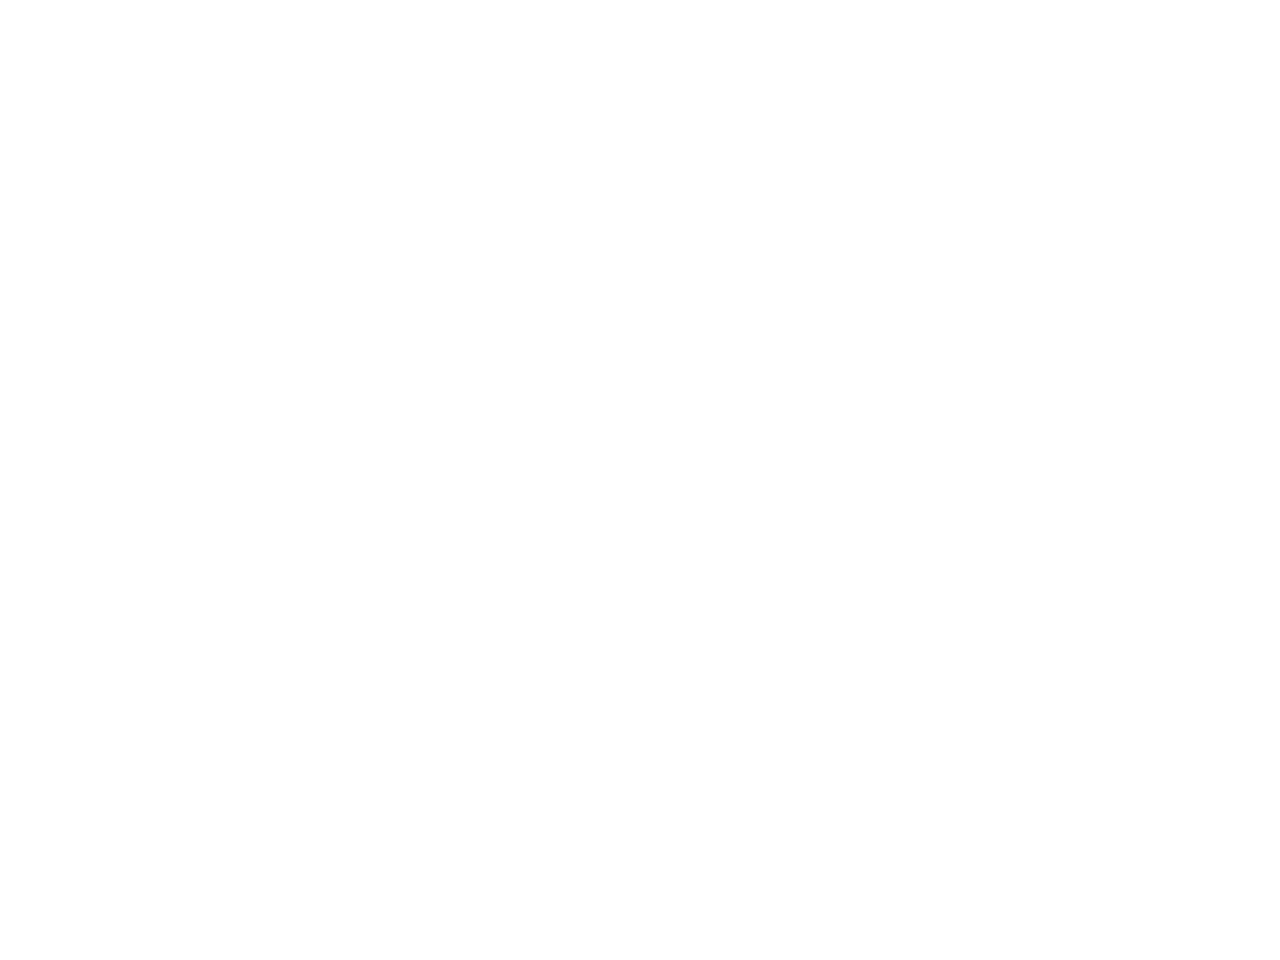

NameError: name 'binning' is not defined

In [26]:
fig = plt.figure()
rebin = 10

y = np.mean(np.array(data['Iq_all'][:]).reshape(-1,binning), axis=0)

col = np.array(sns.color_palette('viridis', len(y)))



for i in range(len(y)):
    plt.plot(qval, y[i], color = col[i])
    

plt.title(f'{samplename} run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')
    
plt.ylim(0, 8)

plt.xlim(12,25)


In [58]:
len(os.listdir(f'../../../raw/{samplename}/p300'))

10001

In [52]:
samples = np.arange(1,10000, 1000)

binning = 300

#air_bckr.background = '../analysis/air_background_SAXS/2_00001.dat'

for sample in samples:
    air_bckr.name=f'{samplename}_{sample:05}' #{:05d} '_abs{:02}_spot{:02}'.format(absorber,spot_id){number1:.2f}
    print(f'{air_bckr.path}/{air_bckr.detector}/{air_bckr.name}.cbf')
    img = load_cbf(f'{air_bckr.path}/{air_bckr.detector}/{air_bckr.name}.cbf')
    plt.imshow(img,vmin=None, vmax=10)
    
    ai = pyFAI.load(air_bckr.integrator)
    
    res = ai.integrate1d(img,binning, mask = 1-v_mask,
                         unit='q_nm^-1', #filename = f'../analysis/{self.name}.dat')
                         filename=f'../analysis/{air_bckr.name}_{sample:05}.dat')
    
    #air_bckr.plot_cbf_image(air_bckr.name)
    #air_bckr.integrate(air_bckr.integrator)
#air_bckr.plot_Iq(air_bckr.name)



../../../raw/G2p1_180_00010//p300/G2p1_180_00010_00001.cbf


../../../raw/G2p1_180_00010//p300/G2p1_180_00010_01001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_02001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_03001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_04001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_05001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_06001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_07001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_08001.cbf
../../../raw/G2p1_180_00010//p300/G2p1_180_00010_09001.cbf


In [43]:
!ls ../../../shared/LaB6_01_00153.poni

asapo-token-clbt.txt  id_rsa.pub	  online-analysis-account.txt
asapo-token.txt       LaB6_01_00153.poni
id_rsa		      Masks


In [15]:
samples = np.arange(201,350, 10)
#samples = np.arange(1,500, 10)

<IPython.core.display.Javascript object>


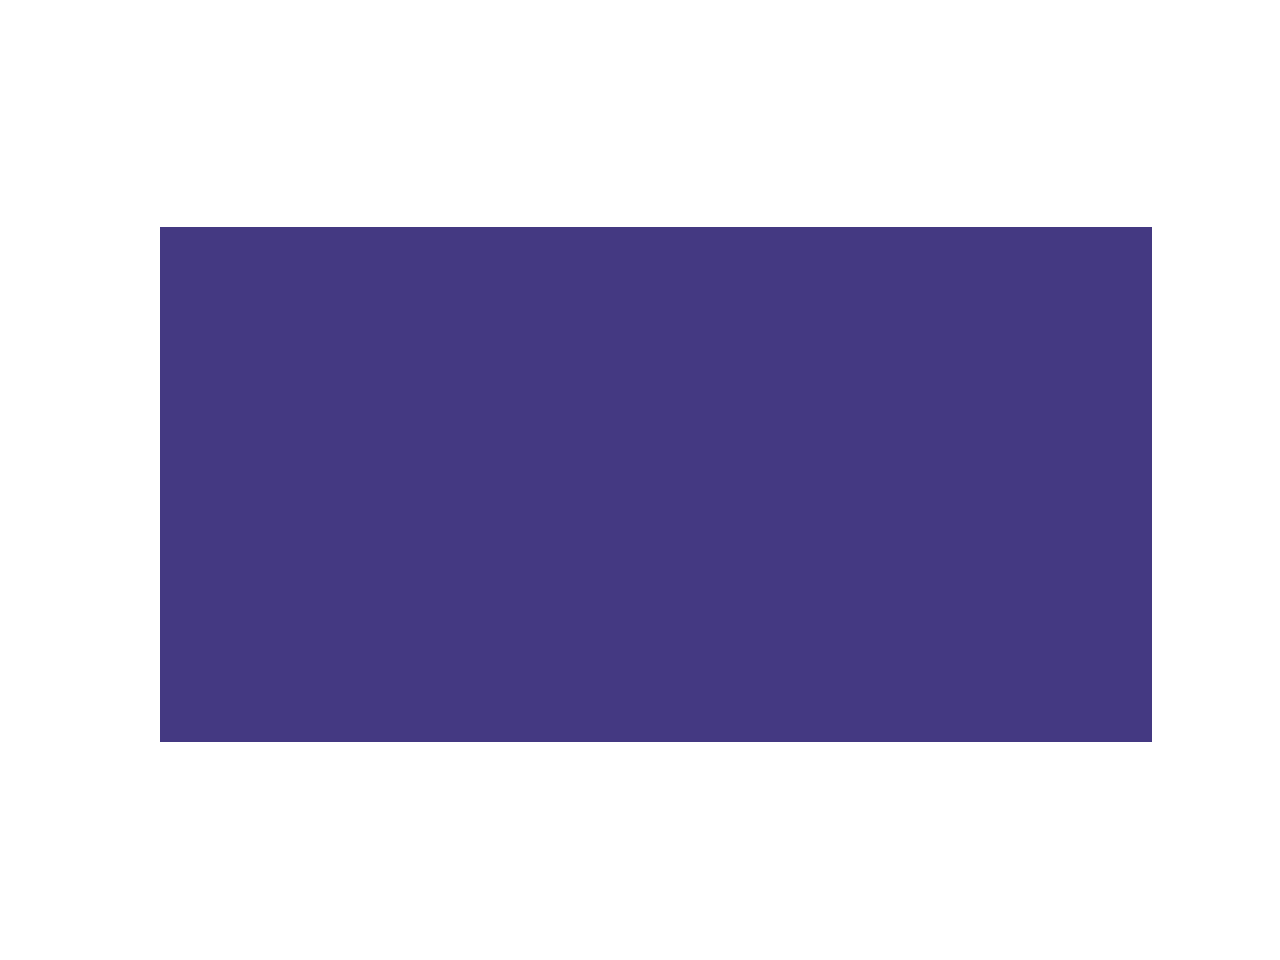

In [53]:
fig = plt.figure()

samplename = 'G2p1_180_00010'#'LaB6_01_00001'#s12p1_23GlyWat_170_3_00001 #LaB6_01_00001/p300/LaB6_01_00001_00001
air_bckr=high_E_XRD()
#air_bckr.scan = 'Tramp'
air_bckr.detector = 'p300'
air_bckr.path = f'../../../raw/{samplename}/'



#runno = 110
samples_all =samples#np.arange(1,2)
col = np.array(sns.color_palette('viridis', len(samples_all)))
#binning = 400

air_bckr.path = f'../../../raw/{samplename}/'

#coefs = np.arange(1,20,2)
col = np.array(sns.color_palette('viridis', len(samples_all)))

#for count, sample in enumerate(samples_all):
#    air_bckr.name=f'{runno}_{sample:05}'
#    air_bckr.plot_Iq(count)
#    print(f"../analysis/{air_bckr.label}_{air_bckr.detector}/{air_bckr.name}.dat")

for count, sample in enumerate(samples_all):
    #sample = samples_all[0]
    air_bckr.name=f'{samplename}_{sample:05}'
    q=air_bckr.load_raw_Iq()[0]
    intens = air_bckr.load_raw_Iq()[1]
    #print(len(intens))
    
    #intens1=intens - np.mean(intens[-50:-25])
    #intens_b = intens1/intens1[323] - w_bckr_int_avg1/w_bckr_int_avg1[323]
    
    #plt.plot(q[:-50],intens1[:-50], color = col[count], marker = 'o', markerfacecolor='none', markersize=3, ls='none', label = f'{sample}')
    #plt.plot(q,intens1-1*w_bckr_int_avg1, color = col[count], marker = 'o', markerfacecolor='none', markersize=3, ls='',label = f'{sample}')

    #plt.plot(q,intens_b, color = col[count],ls='-', label = f'{sample}')
    plt.plot(q,intens, color = col[count],ls='-', label = f'{sample}')





   # plt.plot(q,(intens-w_bckr_int_avg)/np.max(intens-w_bckr_int_avg), color = col[count], marker = 'o', markerfacecolor='none', markersize=3, ls='none', label = f'{sample}')
    
  #  plt.plot(q,intens-w_bckr_int_avg, color = col[count], ls='--', label = f'{sample}')


    
    
plt.title(f'{samplename} run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)
#plt.xlim(15,32)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')

<IPython.core.display.Javascript object>


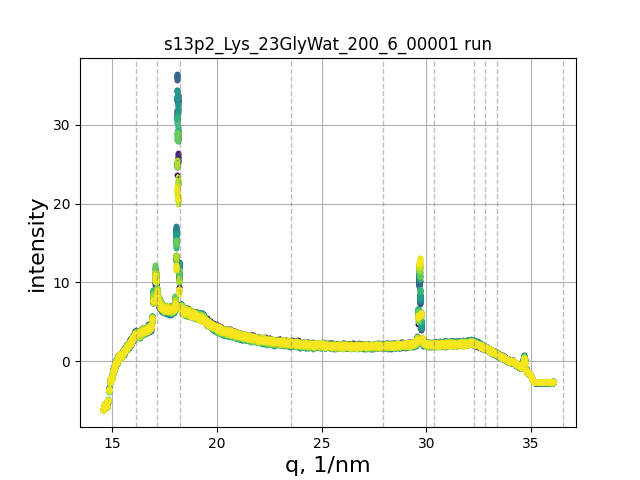

800


In [24]:
fig= plt.figure()


#### background
samplename = 'empty_capillary_295_1_00001'#'LaB6_01_00001'#s12p1_23GlyWat_170_3_00001 #LaB6_01_00001/p300/LaB6_01_00001_00001
empty_cap=high_E_XRD()
#air_bckr.scan = 'Tramp'
empty_cap.detector = 'p300'
empty_cap.path = f'../../../raw/{samplename}/'
#air_bckr.integrator = '../../calibrators/V4_LaB6.poni'#Pilatus_AgBh_day2.poni' #V4_LaB6.poni'
empty_cap.integrator = '../../../processed/calibrators/LaB6_calibration.poni'
empty_cap.absorber = ''

bckr_int = []
for sample in range(1,3):
    empty_cap.name=f'{samplename}_{sample:05}'
    q=empty_cap.load_raw_Iq()[0]
    bckr_int.append(empty_cap.load_raw_Iq()[1])
    intens = empty_cap.load_raw_Iq()[1]
    #print(len(intens))
    
w_bckr_q = q
w_bckr_int_avg = np.mean(bckr_int,0)

w_bckr_int_avg1 = w_bckr_int_avg-np.mean(w_bckr_int_avg[-50:-25])

#plt.plot(w_bckr_q, w_bckr_int_avg1/np.max(w_bckr_int_avg1), color = 'black', marker = 'o', ls = 'none')
print(len(w_bckr_q))



samplename = 's13p2_Lys_23GlyWat_200_6_00001'#'LaB6_01_00001'#s12p1_23GlyWat_170_3_00001 #LaB6_01_00001/p300/LaB6_01_00001_00001
air_bckr=high_E_XRD()
#air_bckr.scan = 'Tramp'
air_bckr.detector = 'p300'
air_bckr.path = f'../../../raw/{samplename}/'
#air_bckr.integrator = '../../calibrators/V4_LaB6.poni'#Pilatus_AgBh_day2.poni' #V4_LaB6.poni'
air_bckr.integrator = '../../../processed/calibrators/LaB6_calibration.poni'
air_bckr.absorber = ''


#runno = 110
samples_all =samples#np.arange(1,2)
col = np.array(sns.color_palette('viridis', len(samples_all)))
#binning = 400

air_bckr.path = f'../../../raw/{samplename}/'

#coefs = np.arange(1,20,2)
col = np.array(sns.color_palette('viridis', len(samples_all)))

#for count, sample in enumerate(samples_all):
#    air_bckr.name=f'{runno}_{sample:05}'
#    air_bckr.plot_Iq(count)
#    print(f"../analysis/{air_bckr.label}_{air_bckr.detector}/{air_bckr.name}.dat")

for count, sample in enumerate(samples_all):
    #sample = samples_all[0]
    air_bckr.name=f'{samplename}_{sample:05}'
    q=air_bckr.load_raw_Iq()[0]
    intens = air_bckr.load_raw_Iq()[1]
    #print(len(intens))
    
    intens1=intens - np.mean(intens[-50:-25])
    intens_b = intens1/intens1[323] - w_bckr_int_avg1/w_bckr_int_avg1[323]
    
    #plt.plot(q[:-50],intens1[:-50], color = col[count], marker = 'o', markerfacecolor='none', markersize=3, ls='none', label = f'{sample}')
    plt.plot(q,intens1-1*w_bckr_int_avg1, color = col[count], marker = 'o', markerfacecolor='none', markersize=3, ls='',label = f'{sample}')

    #plt.plot(q,intens_b, color = col[count],ls='-', label = f'{sample}')



   # plt.plot(q,(intens-w_bckr_int_avg)/np.max(intens-w_bckr_int_avg), color = col[count], marker = 'o', markerfacecolor='none', markersize=3, ls='none', label = f'{sample}')
    
  #  plt.plot(q,intens-w_bckr_int_avg, color = col[count], ls='--', label = f'{sample}')


    
    
plt.title(f'{samplename} run')
plt.grid()
#plt.legend(ncol=6, fontsize = 'small')
plt.xlabel('q, 1/nm', fontsize = 16)
plt.ylabel('intensity', fontsize = 16)
#plt.xlim(15,32)

for i in Ih_ref:
    plt.axvline(x=i*10, c='gray', lw=1, alpha=.5, ls='--')

########### avarage bckgr #######
#intens_avg = []
#for sample in samples_all:
#    air_bckr.name=f'{runno}_{sample:05}'
#    intens_avg.append(air_bckr.load_raw_Iq(binning)[1])
#    q=air_bckr.load_raw_Iq(binning)[0]
    
#plt.plot(q, np.mean(intens_avg,0), lw=4)
#print(np.shape(intens_avg))

#  Ice references

In [9]:


Ih_ref = np.array([1.61297476, 1.71327851, 1.8264895 , 2.35318655, 2.79464445,
       3.03451657, 3.22634856, 3.27789344, 3.33837302, 3.6533046 ])


IX_ref = np.array([2.098, 3.11])
IV_ref = np.array([3.02])
Cu_ref = np.array([2.99, 3.47, 4.91, 5.75, 6])

In [101]:
np.where(q==32.70148)

(array([323, 723]),)

In [ ]:
#LaB6_ref = np.array([1.508 ])

In [73]:
!ls ../analysis/

align_01_00023.dat
raw_p300
s12p1_23GlyWat_170_2_00002_00001_00001.dat
s12p1_23GlyWat_170_2_00002_00002_00002.dat
s12p1_23GlyWat_170_2_00002_00003_00003.dat
s12p1_23GlyWat_170_2_00002_00004_00004.dat
s12p1_23GlyWat_170_2_00002_00005_00005.dat
s12p1_23GlyWat_170_2_00002_00006_00006.dat
s12p1_23GlyWat_170_2_00002_00007_00007.dat
s12p1_23GlyWat_170_2_00002_00008_00008.dat
s12p1_23GlyWat_170_2_00002_00009_00009.dat
s12p1_23GlyWat_170_2_00002_00010_00010.dat
s8p2_Lys_23GlyWat_170_3_00001.dat
s8p2_Lys_23GlyWat_170_3_00002_2.dat
s8p2_Lys_23GlyWat_170_3_00002.dat
s8p2_Lys_23GlyWat_170_3_00003_3.dat
s8p2_Lys_23GlyWat_170_3_00003.dat
